# Maritime Accident Analysis (MAIB 2010–2024) Notebook

### 1️⃣ Setup and Imports

In [3]:
#  Importing required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import streamlit as st
import plotly.express as px
import datetime
import warnings

warnings.filterwarnings("ignore")          # hide pandas warnings
print("Libraries imported")

# Creating folder for processed files
os.makedirs("processed", exist_ok=True)
print("Folder 'processed' ready")

Libraries imported
Folder 'processed' ready


### 2️⃣ Detect CSV Separator

In [5]:
# Function to guess delimiter (comma, semicolon, etc.)
def detect_separator(file_path, sample_lines=5):
    delimiters = [",", ";", "|", "\t"]
    counts = {d: 0 for d in delimiters}
    with open(file_path, "r", encoding="utf-8") as f:
        for _ in range(sample_lines):
            line = f.readline()
            for d in delimiters:
                counts[d] += line.count(d)
    sep = max(counts, key=counts.get)
    print(f"Detected separator for {os.path.basename(file_path)} → '{sep}'")
    return sep

### 3️⃣ Load CSV Function

In [7]:
# Loading a CSV, clean column names, strip strings
def load_csv(file_path):
    sep = detect_separator(file_path)
    df = pd.read_csv(file_path, sep=sep, on_bad_lines='skip', encoding='utf-8')
    # Normalise column names
    df.columns = (df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(r"\s+|-", "_", regex=True)
                  .str.replace(r"[^a-z0-9_]", "", regex=True))
    df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
    print(f"Loaded {os.path.basename(file_path)} → {df.shape}")
    return df

#  Loading of  each raw table
persons = load_csv("affected_persons.csv")
occurs  = load_csv("occurrences.csv")
vessels = load_csv("vessels.csv")

Detected separator for affected_persons.csv → ';'
Loaded affected_persons.csv → (2024, 62)
Detected separator for occurrences.csv → ';'
Loaded occurrences.csv → (5876, 37)
Detected separator for vessels.csv → ';'
Loaded vessels.csv → (6348, 64)


### 4️⃣ Dropping of Columns 

In [9]:
# Keeping only columns that have >20 % data (i.e. <80 % missing)

def drop_high_missing(df, thresh_percent=80, name=""):
    before = df.shape[1]
    missing = df.isna().mean() * 100
    drop = missing[missing > thresh_percent].index
    df = df.drop(columns=drop)
    kept = df.shape[1]
    print(f"{name} – dropped {before-kept} cols (> {thresh_percent}% missing) → {kept} cols")
    return df


# Applying cleaning to each source table
persons = drop_high_missing(persons, 80, "affected_persons")
occurs  = drop_high_missing(occurs , 80, "occurrences")
vessels = drop_high_missing(vessels, 80, "vessels")

affected_persons – dropped 13 cols (> 80% missing) → 49 cols
occurrences – dropped 8 cols (> 80% missing) → 29 cols
vessels – dropped 12 cols (> 80% missing) → 52 cols


### 5️⃣ Common Key Verification

In [11]:
#  We need to  ensure that the join key is present everywhere
key = "occurrence_id"
for name, df in [("persons", persons), ("occurs", occurs), ("vessels", vessels)]:
    if key not in df.columns:
        raise KeyError(f"'{key}' missing in {name}")
    else:
        print(f"Key '{key}' found in {name} ({df[key].nunique()} unique)")


# Let's merge with suffixes so we know the origin
merged = occurs.merge(persons, on=key, how="outer", suffixes=("_occ", "_person"))
merged = merged.merge(vessels, on=key, how="outer", suffixes=("", "_vessel"))
print(f"\nMerged master shape: {merged.shape}")


#  Helper – To find a column that contains any of the patterns
def fuzzy_match(columns, patterns):
    cols_low = [c.lower() for c in columns]
    for pat in patterns:
        for i, c in enumerate(cols_low):
            if pat in c:
                return columns[i]
    return None


#  Mapping of logical field → possible real column patterns
wanted = {
    "occurrence_id":   ["occurrence_id"],
    "date":            ["date", "event"],
    "location":        ["location"],
    "country":         ["country", "nationality"],
    "vessel_name":     ["vessel_name", "name", "vesselname"],
    "vessel_type":     ["vessel_type", "type", "craft"],
    "flag":            ["flag", "state"],
    "gross_tonnage":   ["gross", "gt", "tonnage", "grt"],
    "length_overall":  ["loa", "length_overall", "length"],
    "incident_type":   ["incident", "accident", "port"],
    "injury_level":    ["injury", "level", "severity"],
    "fatalities":      ["fatal", "death", "deaths"],
    "injuries":        ["injur", "casualty"],
    "narrative":       ["narrative", "description", "short_desc"],
    "weather":         ["weather"],
    "damage":          ["damage", "loss"]
}

Key 'occurrence_id' found in persons (1788 unique)
Key 'occurrence_id' found in occurs (5876 unique)
Key 'occurrence_id' found in vessels (5876 unique)

Merged master shape: (6923, 128)


### 6️⃣ DataFrame Creation

In [13]:
# Building final DataFrame using the best-matching columns
selected = []
mapping  = {}

for field, patterns in wanted.items():
    match = fuzzy_match(merged.columns, patterns)
    if match:
        selected.append(match)
        mapping[field] = match
        print(f"{field:15} ← {match}")
    else:
        print(f"{field:15} NOT FOUND")

final = merged[selected].copy()
print(f"\nSelected {len(selected)} columns")

# let's Create a clean datetime column called 'date'
date_col = mapping.get("date")
if date_col:
    final["date"] = pd.to_datetime(final[date_col], errors="coerce")
    print(f"Converted '{date_col}' → 'date' (datetime)") 

# Summary of what we kept and how much is missing
summary = pd.DataFrame({
    "Field":       list(mapping.keys()),
    "Column":      list(mapping.values()),
    "Missing_%":   [round(final[col].isna().mean()*100, 1) for col in mapping.values()]
})

# Saving summary to csv file
summary.to_csv("processed/maib_field_mapping.csv", index=False)
print("\nField Mapping & Missingness:")
summary.head()

occurrence_id   ← occurrence_id
date            ← local_date_main_event_occ
location        ← occurrence_location
country         NOT FOUND
vessel_name     NOT FOUND
vessel_type     ← ship_craft_type_l1
flag            ← flag_state
gross_tonnage   ← gt_gross_tonnage
length_overall  ← loa_length_overall_in_metres
incident_type   ← port_of_accident_l1_occ
injury_level    ← injury_type_l1
fatalities      ← deaths_crew
injuries        ← injury_type_l1
narrative       ← short_description_occ
weather         ← weather
damage          ← loss_of_vessel_damage

Selected 14 columns
Converted 'local_date_main_event_occ' → 'date' (datetime)

Field Mapping & Missingness:


,Field,Column,Missing_%
0,occurrence_id,occurrence_id,0.0
1,date,local_date_main_event_occ,0.0
2,location,occurrence_location,0.0
3,vessel_type,ship_craft_type_l1,64.6
4,flag,flag_state,64.8


### 7️⃣ Data Cleaning & Standardization 

In [15]:
# Removing the raw date column now that we have a clean one
if date_col:
    final = final.drop(columns=[date_col])
    print(f"Dropped raw date column '{date_col}'")

# Deduplicating
print(f"\nRows before dedup: {len(final)}")
final = final.drop_duplicates()
print(f"Rows after dedup : {len(final)}")


# Exporting final analytical table
final.to_csv("processed/maib_cleaned.csv", index=False)
print(f"\nSaved: processed/maib_cleaned.csv → {final.shape}")



Dropped raw date column 'local_date_main_event_occ'

Rows before dedup: 6923
Rows after dedup : 5928

Saved: processed/maib_cleaned.csv → (5928, 14)


### 8️⃣ Dataset Profiling & Initial Insight

In [17]:
df = pd.read_csv("processed/maib_cleaned.csv")
def explore_maritime_accident_data(df): 
    print('📊 Dataset Overview:')
    print(f'\n✅ Number of Rows: {df.shape[0]}')
    print(f'✅ Number of Columns: {df.shape[1]}')
    print("\n📚 Column Names:")
    print(df.columns.tolist())

    print("-" * 60)

    print('\n📈 Numerical Columns Statistical Summary:')
    print(df.describe(exclude='object'))  

    print("\n🔤 Categorical Columns Statistical Summary:")
    print(df.describe(include='object'))

    print("\n🔍 Data Types & Non-Null Values:")
    print(df.info())

    print("\n🧬 Unique Values per Column:")
    print(df.nunique())

    print(f"\n📛 Duplicate Rows: {df.duplicated().sum()}")

    print("\n❓ Missing Values per Column:")
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    print(missing)

    return

In [18]:
explore_maritime_accident_data(df)

📊 Dataset Overview:

✅ Number of Rows: 5928
✅ Number of Columns: 14

📚 Column Names:
['occurrence_id', 'occurrence_location', 'ship_craft_type_l1', 'flag_state', 'gt_gross_tonnage', 'loa_length_overall_in_metres', 'port_of_accident_l1_occ', 'injury_type_l1', 'deaths_crew', 'injury_type_l1.1', 'short_description_occ', 'weather', 'loss_of_vessel_damage', 'date']
------------------------------------------------------------

📈 Numerical Columns Statistical Summary:
       gt_gross_tonnage  loa_length_overall_in_metres  deaths_crew
count       1840.000000                   1840.000000  5928.000000
mean       42549.847962                    132.621293     0.014676
std        58129.781922                    129.543772     0.128405
min            0.000000                      0.000000     0.000000
25%           10.000000                     13.000000     0.000000
50%         2900.000000                     84.000000     0.000000
75%       100000.000000                    280.000000     0.00000

### Insights From Dataset Profiling

Observation,Meaning,Action for Dashboard
"5928 rows, 14 columns",Good size,Keep
deaths_crew: 99.98% zeros,Almost no fatalities,Drop or flag as rare event
injury_type_l1 & injury_type_l1.1 = duplicate,Same data,Drop one
"ship_craft_type_l1, flag_state, gt_gross_tonnage → 4088 missing (69%)","Only ~1,840 vessels have data",Filter to vessel-related incidents only?
occurrence_location: only 11 values,Perfect for filtering,Use in dropdown
weather: 7 values,Great for pie chart,Use
date: 62 unique → ~1 per week,Good for time filter,Use
short_description_occ: 5060 unique,Rich text,Add word cloud later

### Final Clean Up

In [22]:
# Final cleanup for dashboard
df = pd.read_csv("processed/maib_cleaned.csv", parse_dates=["date"])

# 1. Dropping duplicate injury column
df = df.drop(columns=["injury_type_l1.1"], errors="ignore")

# 2. Dropping near-empty numeric columns (keeps dashboard clean)
# Only keep if you want vessel stats
vessel_cols = ["ship_craft_type_l1", "flag_state", "gt_gross_tonnage", "loa_length_overall_in_metres", "loss_of_vessel_damage"]
df_vessel = df.dropna(subset=vessel_cols, how="all")  # keep rows with ANY vessel data
print(f"Vessel-related incidents: {len(df_vessel)} / {len(df)}")

# 3. Now, let's clean up column names for dashboard
df_vessel = df_vessel.rename(columns={
    "occurrence_id": "ID",
    "occurrence_location": "Location",
    "ship_craft_type_l1": "Vessel Type",
    "flag_state": "Flag",
    "gt_gross_tonnage": "Gross Tonnage",
    "loa_length_overall_in_metres": "Length (m)",
    "port_of_accident_l1_occ": "Port",
    "injury_type_l1": "Injury Type",
    "deaths_crew": "Fatalities",
    "short_description_occ": "Description",
    "weather": "Weather",
    "loss_of_vessel_damage": "Damage",
    "date": "Date"
})

# 4. Saving clean version for Dasboard: 
df_vessel.to_csv("processed/maib_dashboard_ready.csv", index=False)
print("Dashboard-ready dataset saved!")

Vessel-related incidents: 1840 / 5928
Dashboard-ready dataset saved!


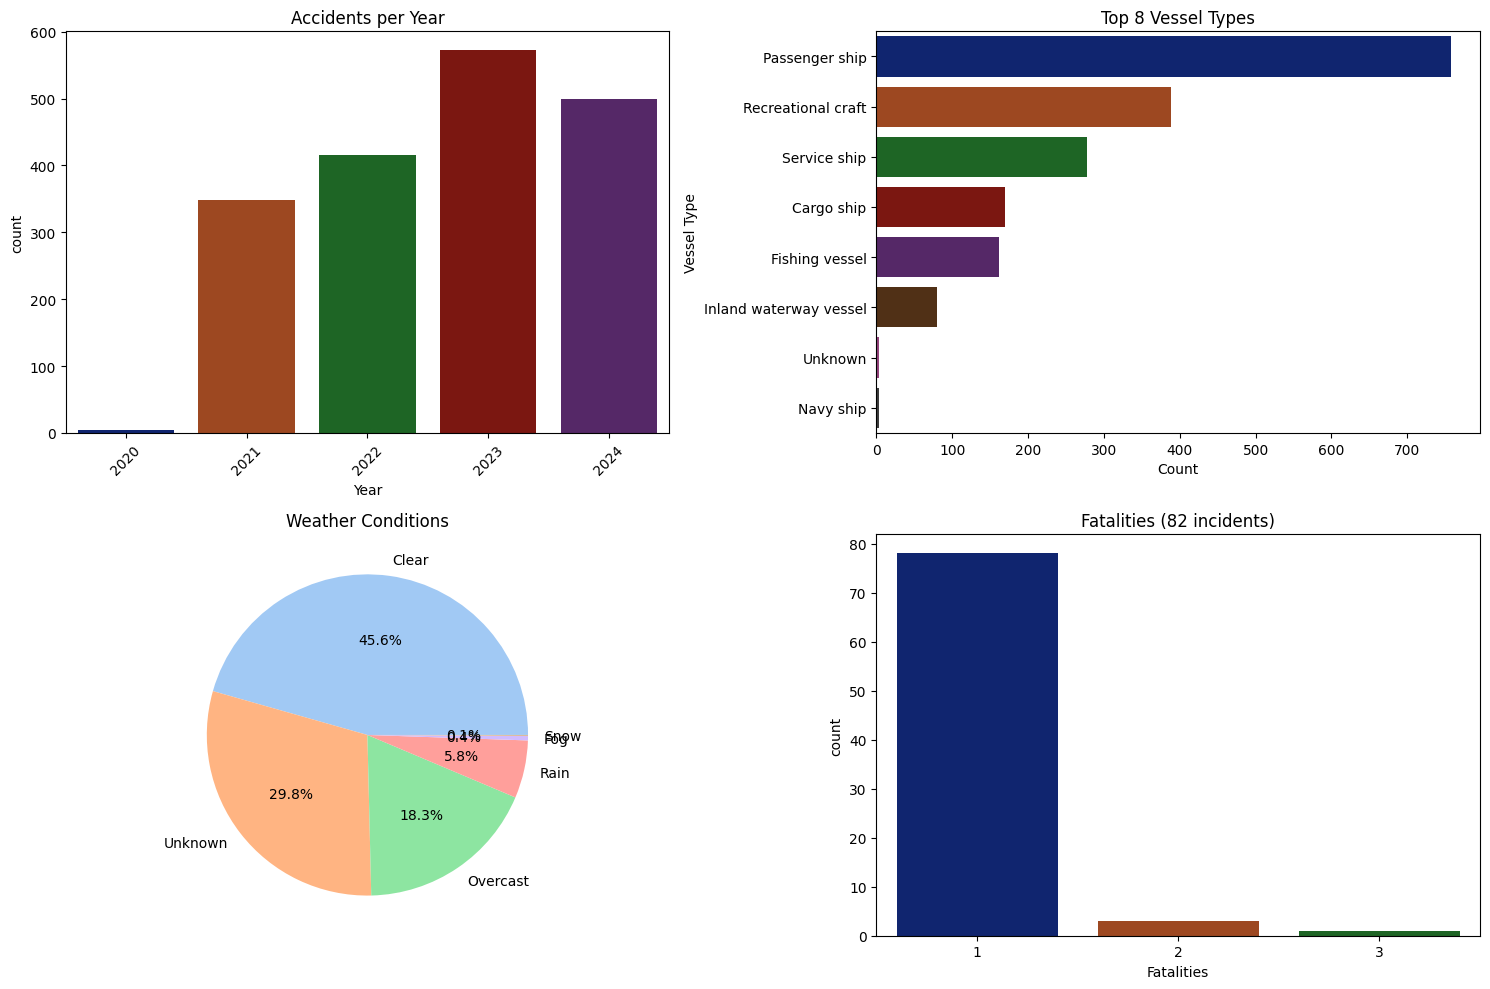

In [28]:
# Quick EDA Plots
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("processed/maib_dashboard_ready.csv", parse_dates=["Date"])
df["Year"] = df["Date"].dt.year

plt.figure(figsize=(15, 10))

# 1. Accidents per year 
plt.subplot(2, 2, 1)
sns.countplot(data=df, x="Year", hue="Year", palette="dark", legend=False)
plt.title("Accidents per Year")
plt.xticks(rotation=45)

# 2. Top vessel types
plt.subplot(2, 2, 2)
top_vessels = df["Vessel Type"].value_counts().head(8)
sns.barplot(x=top_vessels.values, y=top_vessels.index, hue=top_vessels.index, palette="dark", legend=False)
plt.title("Top 8 Vessel Types")
plt.xlabel("Count")

# 3. Weather distribution
plt.subplot(2, 2, 3)
weather_counts = df["Weather"].value_counts()
plt.pie(weather_counts, labels=weather_counts.index, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Weather Conditions")

# 4. Fatalities (rare events)
plt.subplot(2, 2, 4)
fatal_df = df[df["Fatalities"] > 0]
if not fatal_df.empty:
    sns.countplot(data=fatal_df, x="Fatalities", hue="Fatalities", palette="dark", legend=False)
    plt.title(f"Fatalities ({len(fatal_df)} incidents)")
else:
    plt.text(0.5, 0.5, "No fatalities\nin dataset", ha="center", va="center", fontsize=14, transform=plt.gca().transAxes)
    plt.title("Fatalities")

plt.tight_layout()
plt.show()